In [2]:
import numpy as np
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import Counter
import operator as op

import os
from together import Together
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

## Section 1: Existing CVs data analysis

Here is a recent collection of CVs from https://github.com/Stereotypes-in-LLMs/recruitment-dataset 
We will use these CVs as the basis for generating cover letters for our hiring model

In [113]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')  # raw dataframe

# Filter the dataframe minimum cv length
MIN_CV_LENGTH = 500
filtered_df = df.loc[df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

In [115]:
# See the top 20 most frequent positions
top20df = filtered_df.groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)
print(top20df)

                            Moreinfo  Looking For  Highlights  \
Position                                                        
Project Manager                 5299         2582        3298   
QA Engineer                     4886         2392        2577   
Junior QA Engineer              3333         1847        2206   
Front-end developer             3045         1602        1475   
Manual QA Engineer              2683         1243        1349   
UI/UX Designer                  2521         1303        1364   
Java Developer                  2246         1257        1167   
IT Recruiter                    1947          852         844   
Junior Front-end Developer      1861         1116        1270   
UX/UI Designer                  1771          967        1002   
Front-End Developer             1744          914         891   
Business Analyst                1710          794         947   
Python Developer                1509          835         821   
Product manager          

### True Labels

In [118]:
# Assign each entry in the filtered dataframe a label (0 for negative, 1 for positive)
POSITIVE_LABEL, NEGATIVE_LABEL = 1, 0

POSITIVE_POSITION = "Project Manager"
POSITIVE_KEYWORD = "Project Manager"

NEGATIVE_POSITION = "QA Engineer"   # "Java Developer"
NEGATIVE_KEYWORD = "QA"             # "Java"

'''
Given a row of the dataframe, returns 
    1 if the entry belongs to the positive class
    0 if the entry belongs to the negative class
    NA if the entry is to be excluded
Can be thought of as "h" (although this function does not operate on a feature vector)

Currently, the positive class are entries where
   1. The primary keyword is "Project manager" (case insensitive) AND  
   2. The position contains "Project manager" (case insensitive),
while the negative class are entries where
   1. The primary keyword is "Java Developer" (case insensitive) AND  
   2. The position contains "Java Developer" (case insensitive),

Examine the effect of the second condition with
   print(labeled_df.loc[ (labeled_df["True Label"] == NEGATIVE_LABEL) & (labeled_df["Primary Keyword"] == PM) ])
'''
import re
def trueLabelFunction(row):
    # print(f"id = {row['id']}, Position = {row['Position']}, Primary Keyword = {row['Primary Keyword']}")
    
    # Positive match
    positivePositionRegex = re.compile(f'.*{POSITIVE_POSITION}.*', re.IGNORECASE)
    isPositivePositionMatch: bool = isinstance(row["Position"], str) and bool(positivePositionRegex.match(row["Position"]))
    positivePrimaryKeywordRegex = re.compile(f'{POSITIVE_KEYWORD}', re.IGNORECASE)
    isPositivePrimaryKeywordMatch: bool = isinstance(row["Primary Keyword"], str) and bool(positivePrimaryKeywordRegex.match(row["Position"]))

    isPositiveMatch: bool = isPositivePositionMatch and isPositivePrimaryKeywordMatch

    # Negative match
    negativePositionRegex = re.compile(f'.*{NEGATIVE_POSITION}.*', re.IGNORECASE)
    isNegativePositionMatch: bool = isinstance(row["Position"], str) and bool(negativePositionRegex.match(row["Position"]))
    negativePrimaryKeywordRegex = re.compile(f'{NEGATIVE_KEYWORD}', re.IGNORECASE)
    isNegativePrimaryKeywordMatch: bool = isinstance(row["Primary Keyword"], str) and bool(negativePrimaryKeywordRegex.match(row["Position"]))

    isNegativeMatch: bool = isNegativePositionMatch and isNegativePrimaryKeywordMatch

    if isPositiveMatch:
        return POSITIVE_LABEL
    elif isNegativeMatch:
        return NEGATIVE_LABEL
    else:
        return pd.NA

# Creates a true label column
labeled_df = filtered_df.copy()
labeled_df["True Label"] = labeled_df.apply(trueLabelFunction, axis=1)
labeled_df.dropna()

,Position,Moreinfo,Looking For,Highlights,Primary Keyword,English Level,Experience Years,CV,CV_lang,id,__index_level_0__,True Label
129971,project manager,"Seven years of experience in Ericsson, leading...",Professional growth. High culture innovative t...,More then three E2E IT multi-vendor projects (...,Project Manager,fluent,11.0,More then three E2E IT multi-vendor projects (...,en,0e3da2ed-e213-5823-ad90-bd8504aab3ae,154201,1
129974,Project manager,2+ years of experience in project management a...,I prefer working in/managing small teams (up t...,Initiating and launching my own educational pr...,Project Manager,fluent,3.0,Initiating and launching my own educational pr...,en,8adcec30-5311-5c2e-8d3a-6f06cb38e33c,154204,1
129975,Project manager,3+ years of experience managing IT projects\r\...,Clear understanding of company mission and my ...,Successfully delivered end-to-end projects;\r\...,Project Manager,intermediate,3.0,Successfully delivered end-to-end projects;\r\...,en,35355781-166e-5f50-9970-86d240ba3a7c,154205,1
129976,Project manager,4 years experience in project/product manageme...,I'm looking for a company with a friendly atmo...,- Managed to resolve situations on a complicat...,Project Manager,fluent,4.0,- Managed to resolve situations on a complicat...,en,121619c0-044f-564d-8929-a347c61fc67d,154206,1
129977,Project manager,4+ years of experience in HR management and re...,Looking for interesting projects in the field ...,Experience of building a few HR and recruitmen...,Project Manager,upper,5.0,Experience of building a few HR and recruitmen...,en,47fab0ac-5298-5a43-a619-87deb840386c,154207,1
...,...,...,...,...,...,...,...,...,...,...,...,...
154016,QA Team Lead / Senior QA Engineer,Professional skills:\r\n• Strong knowledge in ...,I'm looking for opportunity of relocation to C...,• Growth from beginner specialist to strong on...,QA,upper,11.0,• Growth from beginner specialist to strong on...,en,329d227a-633c-5f79-b287-9b6fa9cdab80,178246,0
154018,"QA Team Lead, Senior QA Engineer (GameDev)",Senior QA Engineer:\r\n- Led quality assurance...,- Seek a company that fosters a friendly and s...,- Spearheaded the establishment of the complet...,QA,upper,4.0,- Spearheaded the establishment of the complet...,en,e74b8434-35db-5e69-9b68-90bbec1fe52e,178248,0
154019,"QA Team Lead, Senior QA Engineer(Manual)","Slice - Sr. QA Engineer, Team Lead - Full-time...",Competitive salary\r\nGood social package\r\nW...,Manual testing web/desktop/mobile applications...,QA,intermediate,11.0,Manual testing web/desktop/mobile applications...,en,fc46ad75-1338-5a9c-ace3-0af4199c0d2e,178249,0
154038,QA Tech Lead / Senior Automation QA Engineer /...,"- Perform applications functional, usability, ...",- Manual testing is not more than 40% of testi...,- Mentoring of QAs and Devs how to write tests...,QA Automation,fluent,8.0,- Mentoring of QAs and Devs how to write tests...,en,c5fc0f38-0c9b-5ef0-8667-7a8a94b025e3,178268,0


In [122]:
# Prints the sizes of the positive and negative class
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(NEGATIVE_LABEL, default=0)
# print(f"positiveClassSize = {positiveClassSize}")
# print(f"negativeClassSize = {negativeClassSize}")
print(f"proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    6753
0    6379
Name: count, dtype: int64
proportion of positives = 0.5142400243679561


In [ ]:
pm = "Project Manager"
java_dev = "Java Developer"
pm_occupation_df = df[df["Position"]==pm]
java_dev_occupation_df = df[df["Position"]==java_dev]

In [5]:
# example entry 
"".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n')

['',
 '01.11.2018   PE «SoloService»Position: Java Developer.• Software design, investigating technical solutions• Reviewing project documentation, analyzing requirements• Troubleshoot and analyze problems identified in the system software04.05.2018 – 31.10.2018   PE «SoloService» Position: IT Support Specialist.• provide user support for computer systems and user applications, including: website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux);• installing and configuring computer hardware, software, mobile devices, video projection systems and audio systems;26.09.2017 – 03.05.2018   LLC «ЕКО» (supermarkets ЕКО)Position: Head of Project department.• project management of modernization, automation, reconstruction and  construction of trade objects;• to control the timing of project delivery;• establishment of consolidate budgets of projects;• organization of meetings, presentation of project (technology, visualization, business plan);• collaboration with pro

In [6]:
pm_occupation_df.iloc[0].to_dict()['CV']

'- Managing multiple projects at a time\r\n- Experience working with foreign customers\r\n- Successful team management with up to 7 members\r\n- SDLC understanding in terms of management perspective\r\n- Good communication skills\r\n- Project processes organization with Agile approaches(Agile, Kanban)\r\n- Working with the project documentation using Atlassian and Google services\r\n- Understanding of proper time management with further timelines control\r\n- Internal projects acceptance before delivering to the customer\r\n- Resources planning\r\n- Taking part in potential team members interviewing\r\n- Defend both customer and the company interests\r\n- Account management, pre-sales, upsales, risk management\n01.2020 - 04.2020\r\nProject manager/Account manager\r\n1. Working as a PM was responsible for project planning, resource planning, business communication, upsales.\r\n2. As an AM was involved in Outsataff projects monitoring and support. A few of the main responsibilities were 

In [7]:
## TODO: further explorations of CV data, bring 2-3 insights about the CV itself and Insights and highlights

#First: What words are used more? Collaboration base Terms or Technical terms?

def plot_position_words(position):
    pm_occupation_df = df[df["Position"]==position]
    all_cvs = "\n".join(list(pm_occupation_df['CV']))
    all_words = all_cvs.split(" ")
    all_long_words = [word for word in all_words if len(word) > 10]
    word_counts = Counter(all_long_words)
    top_ten = word_counts.most_common(20)
    words =  [item[0] for item in top_ten]
    counts = [item[1]/len(pm_occupation_df) for item in top_ten]
    #fig, ax = plt.subplots(figsize =(10, 6))
    return [words, counts]
    # Horizontal Bar Plot
    #ax.barh(words, counts)
    #ax.set_title('Frequency of Words in ' + position + " CVs",loc ='left', )
    #ax.invert_yaxis()
 
#plot_position_words("Java Developer")

#fig, axs = plt.subplots(4, 5, figsize=(100, 100))
#fig.suptitle('Word Frequencies')

'''for i in range(0, len(top_twenty_jobs)):
    print(top_twenty_jobs[i])
    plot_position_y = i % 4
    plot_position_x = i%5
    print(plot_position_y, plot_position_x)
    axs[plot_position_y, plot_position_x].set_title('Frequency of Words in ' + top_twenty_jobs[i] + " CVs",loc ='left', )
    axs[plot_position_y, plot_position_x].invert_yaxis()
    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])
fig.savefig("word-frequncies.png")'''


'for i in range(0, len(top_twenty_jobs)):\n    print(top_twenty_jobs[i])\n    plot_position_y = i % 4\n    plot_position_x = i%5\n    print(plot_position_y, plot_position_x)\n    axs[plot_position_y, plot_position_x].set_title(\'Frequency of Words in \' + top_twenty_jobs[i] + " CVs",loc =\'left\', )\n    axs[plot_position_y, plot_position_x].invert_yaxis()\n    axs[plot_position_y, plot_position_x].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])\nfig.savefig("word-frequncies.png")'

## Section 2: Prompting LLMs for generating cover letters 

Now we will use a generic prompt to generate a cover letters for each resume using API calls

In [8]:
# Load the YAML file
with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

In [12]:
# example usage of Together AI 

client = Together(api_key=together_api_key) 
position = "Project Manager"
response = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": "Modify this resume to help me get a "+ position+" Job:" + "".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n'))}],
)
coverletter = response.choices[0].message.content

In [13]:
print(coverletter)

 [Your Name]
[Address]
[City, State ZIP]
[Phone Number]
[Email Address]

PROFESSIONAL EXPERIENCE

Project Manager, LLC "ЕКО" (supermarkets ЕКО), [City, State]
September 2017 - Present

* Oversee project management of modernization, automation, reconstruction, and construction of trade objects, ensuring timely delivery and adherence to consolidated budgets.
* Collaborate with project members, contractors, and suppliers, fostering strong relationships and effective communication.
* Organize meetings and present projects, utilizing technology, visualization, and business plans to effectively convey project details and objectives.
* Develop architectural drawings and technical specifications for supermarkets and shopping centers using AutoCAD.

IT Support Specialist, PE "SoloService", [City, State]
May 2018 - October 2018

* Provided user support for computer systems and user applications, including website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux).
* Ins

In [14]:
# TODO: 

# decide on a prompt and use prompt + CVs to generate cover letters 
prompt = "Modify the following resume to help get a *POSITION* "

In [19]:
# Script to generate resumes

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]


with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')

java_dev_occupation_df = df[df["Position"]=="Java Developer"]

def create_modified_resumes(unmodifiedresumes, num_of_resumes, originalposition):
    # example usage of Together AI 
    modifiedresumes = []
    for resume in unmodifiedresumes[0:num_of_resumes]:
        client = Together(api_key=together_api_key) 
        position = "Project Manager"
        response = client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1",
            messages=[{"role": "user", "content": "Modify the following resume to help me get a "+ position+" Job:" + resume}],
        )

        #Trim out the AI conversation (I hope this faldskraewr! stuff).
        output = response.choices[0].message.content
        output = output[output.find("\n"):output.rfind('\n')]
        output = "".join("".join(output.split('\r\n')).split('\n'))
        modifiedresumes.append(output)

    with open(originalposition+'to'+position+'.txt', 'w') as f:
        for resume in modifiedresumes:
            f.write(f"{resume}\n")
    return modifiedresumes

java_to_pm_mod_resume = create_modified_resumes(list(java_dev_occupation_df['CV']), 2, "java")

## Section 3: Training a simple hiring model 

We will now use fast text to create a hiring model which will make a binary decision of whether we should hire a candidate or not based on years of experience as the ground truth. Fasttext (https://fasttext.cc/) is an easy to use library you can run on your local computer to build text classification models or get embedding representations for different inputs. Here we will use Fast text to generate embeddings and then use a logistic classifier on top of it. 

### Step 1: Generate embeddings from cover letters 

In [20]:
import fasttext
# load fast text vectors
ft = fasttext.load_model('../../../Downloads/cc.en.300.bin') # replace with your own path to the vector binary

In [21]:
def get_vector_rep(text): 
    tokens = text.lower().split() # feel free to use other tokenizations if you want
    if len(tokens) ==0:
        print(tokens)
        print(text)
        print(len(text))
    for i, t in enumerate(tokens):
        if i == 0:
            vec = ft.get_word_vector(t)
        else:
            vec += ft.get_word_vector(t)
    return vec

In [22]:
datasets = {0:list(java_dev_occupation_df['CV']), 1: list(pm_occupation_df['CV'])}

vector_rep = get_vector_rep("".join("".join(java_dev_occupation_df.iloc[0].to_dict()['CV'].split('\r\n')).split('\n')))

In [23]:
def create_test_train_dataset(true_dataset, false_dataset):
    x_s = []
    y_s = []
    for cv_s in true_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(1)
    for cv_s in false_dataset:
        x_s.append(get_vector_rep("".join("".join(cv_s.split('\r\n')).split('\n'))))
        y_s.append(0)
    return [x_s, y_s]

In [24]:
"".join("".join(datasets[0][0].split('\r\n')).split('\n'))

'01.11.2018   PE «SoloService»Position: Java Developer.• Software design, investigating technical solutions• Reviewing project documentation, analyzing requirements• Troubleshoot and analyze problems identified in the system software04.05.2018 – 31.10.2018   PE «SoloService» Position: IT Support Specialist.• provide user support for computer systems and user applications, including: website, mobile app, intranet, Outlook, Skype, operating systems (Windows and Linux);• installing and configuring computer hardware, software, mobile devices, video projection systems and audio systems;26.09.2017 – 03.05.2018   LLC «ЕКО» (supermarkets ЕКО)Position: Head of Project department.• project management of modernization, automation, reconstruction and  construction of trade objects;• to control the timing of project delivery;• establishment of consolidate budgets of projects;• organization of meetings, presentation of project (technology, visualization, business plan);• collaboration with project m

In [25]:
# TODO: build vector embeddings and lables for positive label examples experience more than 5 years, negative examples less than 5
training_data = create_test_train_dataset(datasets[1], datasets[0])

### Step 2: Build classifier for resume classification

In [26]:
no_applicant_modification_data = [training_data[0], training_data[1]]

In [27]:
#Generates (model, x_test, y_test) based on input (x, y) data
def train_model(data):
    x = data[0]
    y=data[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf = LogisticRegression(random_state=16)
    clf.fit(x_train, y_train)

    p = clf.predict_proba(x_test)[:, 1]
    p_acc = accuracy_score(y_test, p > 0.5)
    print("clf_acc", p_acc)
    return [clf, x_test, y_test]

#Plots confusion matrix
def plot_conf_matrix(xtest, ytest, output_model):
    cnf_matrix = metrics.confusion_matrix(ytest, output_model.predict(xtest))
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

In [81]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))
        #print("new")


## Section 4: Simulation manipulations and evaluate disparity 

In [ ]:
test_resumes = []

with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        if len(line) >1:
            test_resumes.append(get_vector_rep(line))

/Users/ch/miniforge3/envs/llm_jobs/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf_acc 0.9648780487804878
Intercept: [-0.34687288]


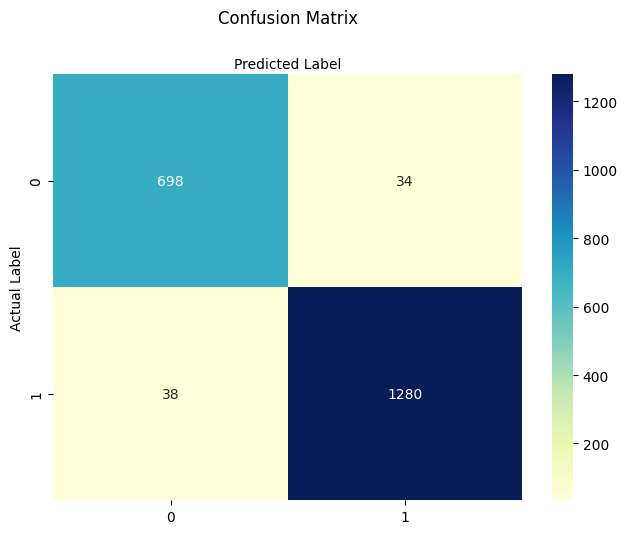

In [160]:
#Question 1: Let's train a model on just the non-modified resumes. Does modify the Java SWE resumes increase the chance of acceptance?

#train model on unmodified data
model_output = train_model(no_applicant_modification_data)
print('Intercept: {0}'.format(model_output[0].intercept_))
plot_conf_matrix(model_output[1], model_output[2], model_output[0])

In [161]:
#Predict on modified JAVA SWE data. Do these "0" datapoints became incorrectly labeled as 1?
java_predictions = model_output[0].predict(test_resumes)
ratiooffalsepositives = len([i for i in java_predictions if i==1])/len(java_predictions)
print("THe ratio of FP in the Java SWE modified data, amongst all the JAVA SWE is", ratiooffalsepositives, ".")

THe ratio of FP in the Java SWE modified data, amongst all the JAVA SWE is 0.22795153564384332 .


In [ ]:
#train model on unmodified data
model_output = train_model(no_applicant_modification_data)
print('Intercept: {0}'.format(model_output[0].intercept_))
plot_conf_matrix(model_output[1], model_output[2], model_output[0])

In [158]:
datasets[0] = test_resumes

In [170]:
with open("javadeveloper_to_pm.text", 'r') as f:
    for line in f:
        print(line)
        break

**[Your Name]****Contact Information:**[Include your contact information here]**Summary:**Experienced Project Manager with a proven track record of delivering projects on time and within budget. Skilled in project management, team leadership, and technical problem-solving. Proficient in AutoCAD, Windows, and Linux.**Experience:****Project Manager, LLC "ЕКО" (supermarkets ЕКО)***26.09.2017 – 03.05.2018** Managed the modernization, automation, reconstruction, and construction of trade objects, ensuring timely delivery and consolidated budgets.* Organized meetings and presented project technology, visualization, and business plans.* Collaborated with project members, contractors, and suppliers to ensure project success.**Chief Design Engineer, Project Department, LLC "ЕКО" (supermarkets ЕКО)***20.04.2012 – 25.09.2017** Developed architectural drawings and technical specifications for supermarkets and shopping centers in AutoCAD.* Collaborated with project managers to ensure project succes